Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Leer los datos

In [2]:
ventas = pd.read_csv('ventas.csv')
productos = pd.read_csv('20230223_productos.csv')
clientes = pd.read_csv('customers_sampled.csv')

# Convertir 'calmonth' a formato de fecha
ventas['date'] = pd.to_datetime(ventas['calmonth'], format='%Y%m')
# date como índice
ventas.drop(columns='calmonth', inplace=True)

Vamos a juntar los datos de ventas con sus productos correspondientes

In [3]:
ventas = ventas.rename(columns={'material': 'Material'})
ventas_productos = pd.merge(ventas, productos, on='Material')
ventas_productos = ventas_productos.drop(columns=['Productos_Por_Empaque', 'BrandPresRet', 'Presentation', 'SegAg', 'SegDet', 'GlobalSubcategory', 'BrandGrouper', 'Returnability', 'Pack', 'Flavor', 'Container', 'Ncb', 'MLSize'])

Establecer el target

Un producto nuevo exitoso se define como un producto que se consumió por 5 meses seguidos, 2 de prueba y los 3 siguientes meses de compra.Marcaremos 1 para aquellos productos que cumplan este requisito y 0 para aquellos que no.

In [4]:
def label_data(df):
    # Ensure the DataFrame is sorted correctly
    df = df.sort_values(['CustomerId', 'Material', 'date']).reset_index(drop=True)
    
    # Create a new column 'ConsecutivePurchase' initialized to 0
    df['ConsecutivePurchase'] = 0
    
    # Group by CustomerId and Material to apply the rolling check within each group
    for (customer, material), group in df.groupby(['CustomerId', 'Material']):
        # Create a rolling count to check for 5 consecutive months with purchases
        group = group.copy()  # Avoid modifying the original DataFrame
        group['RollingCount'] = (group['uni_box'] > 0).rolling(window=5, min_periods=5).sum()
        
        # Find the index of the first row in a series of 5 consecutive purchases
        first_five_months_idx = group.loc[group['RollingCount'] == 5].index.min() - 4
        if pd.notna(first_five_months_idx) and first_five_months_idx >= 0:
            df.loc[first_five_months_idx, 'ConsecutivePurchase'] = 1
    
    # Drop the helper column 'RollingCount' if it exists
    if 'RollingCount' in df.columns:
        df.drop(columns=['RollingCount'], inplace=True)
    
    return df

df = label_data(ventas_productos) 
df.head()

,CustomerId,Material,uni_box,date,Material_desc,ProdKey,Brand,Size,ProductType,ProductCategory,GlobalCategory,GlobalFlavor,ConsecutivePurchase
0,499920078,1,1.5005,2020-02-01,COCA-COLA 12 OZ RET VID 24B,COLAS REGULAR INDIVIDUAL RETORNABLE,COCA-COLA,INDIVIDUAL,COLAS REGULAR,REFRESCOS,REFRESCOS,COLA,0
1,499920078,24,0.5284,2019-09-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,REFRESCOS,LIMA LIMÓN,1
2,499920078,24,0.5284,2019-11-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,REFRESCOS,LIMA LIMÓN,0
3,499920078,24,0.5284,2020-01-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,REFRESCOS,LIMA LIMÓN,0
4,499920078,24,0.5284,2020-04-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,REFRESCOS,LIMA LIMÓN,0


Dividiendo los datos

In [5]:
cutoff_date = '2022-06-01' # datos de entrenamiento
df_filtered = df[df['date'] <= cutoff_date] # datos de test (ultimos 6 meses)

Creación de features para el modelo

Vamos a crear un indicador que nos va a ayudar a determinar la importancia de un cliente de acuerdo a sus ventas y la tendencia de estas.

El indicador es calcuado tomando el porcentaje de ventas que un cliete tiene sobre las ventas totales de un tipo de producto y multiplicandolo por la tendencia de las ventas de ese cliente (determinado por la pendiente de las ventas).

In [6]:
ventas_totales_productos = df_filtered.groupby('ProductType')['uni_box'].sum()
compras_totales_por_customerid = df_filtered.groupby("CustomerId")['uni_box'].sum()
df_filtered["Compras totales del cliente por producto"] = df_filtered.groupby(["CustomerId", "ProductType"])["uni_box"].transform('sum')
df_filtered["Ventas totales del producto"] = df_filtered["ProductType"].map(ventas_totales_productos)
df_filtered["Percentage of product type sales of the total sales"] = (df_filtered["Compras totales del cliente por producto"] / df_filtered["Ventas totales del producto"]) * 100

In [7]:
df_filtered["sales_slope_by_customer"] = df_filtered.groupby("CustomerId")["uni_box"].transform(lambda x: np.polyfit(range(len(x)), x, 1)[0])
df_filtered["Indicator"] = df_filtered["sales_slope_by_customer"] * df_filtered["Percentage of product type sales of the total sales"]

Vamos a mantener solo las columnas que nos interesan

In [8]:
df_filtered.reset_index(drop=False, inplace=True)
df_filtered = df_filtered[["Compras totales del cliente por producto", "Ventas totales del producto", "Percentage of product type sales of the total sales", "sales_slope_by_customer", "Indicator", "ConsecutivePurchase", "CustomerId", "ProductType", "date"]]

Aparte del indicador, vamos a crear features que nos indiquen la cantidad de producto que compra un cliente por cada tipo de producto.

In [9]:
df_filtered_amount = df_filtered.groupby(['CustomerId', 'ProductType']).aggregate({'ConsecutivePurchase': 'sum'})

df_filtered_amount = df_filtered_amount.unstack().fillna(0)
df_filtered_amount = df_filtered_amount.reset_index()
df_filtered_amount.columns = df_filtered_amount.columns.droplevel()

df_filtered_amount.columns.name = None

# add a _AMOUNT suffix to the column names
df_filtered_amount.columns = [str(col) + ' AMOUNT' for col in df_filtered_amount.columns]

# rename the first column
df_filtered_amount = df_filtered_amount.rename(columns={df_filtered_amount.columns[0]: 'CustomerId'})

df_filtered_amount.head() # train

,CustomerId,AGUA FUNCIONAL AMOUNT,AGUA MINERAL AMOUNT,AGUA PURIFICADA AMOUNT,AGUA SABORIZADA AMOUNT,BEBIDA ALCOHOLICA AMOUNT,BEBIDAS DE SOYA AMOUNT,BEBIDAS ENERGETICAS AMOUNT,BEBIDAS INFANTILES AMOUNT,BEBIDAS REFRESCANTES AMOUNT,...,ISOTONICOS AMOUNT,JUGOS Y NECTARES AMOUNT,LECHE UHT ESPECIALIZADA AMOUNT,LECHE UHT REGULAR AMOUNT,LECHE UHT SABORIZADA AMOUNT,MIXTOS AMOUNT,NARANJADAS AMOUNT,SABORES LIGHT AMOUNT,SABORES REGULAR AMOUNT,TE AMOUNT
0,499920078,0.0,3.0,4.0,0.0,1.0,0.0,1.0,0.0,2.0,...,8.0,8.0,1.0,0.0,5.0,0.0,1.0,1.0,14.0,1.0
1,499920499,0.0,7.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,...,7.0,12.0,0.0,0.0,2.0,0.0,2.0,0.0,13.0,0.0
2,499921473,0.0,5.0,4.0,2.0,1.0,1.0,4.0,3.0,2.0,...,4.0,11.0,1.0,2.0,5.0,0.0,2.0,0.0,24.0,3.0
3,499921557,0.0,6.0,4.0,1.0,0.0,2.0,3.0,3.0,2.0,...,9.0,8.0,1.0,2.0,8.0,0.0,4.0,0.0,35.0,6.0
4,499921908,0.0,6.0,7.0,6.0,0.0,5.0,3.0,3.0,3.0,...,8.0,14.0,1.0,1.0,5.0,0.0,6.0,0.0,33.0,5.0


Por ahora ya se crearon todas nuestras features para el set de entrenamiento, ahora vamos a pasar estas variables al set de prueba. 

Por que asi? Principalmente para evitar data leakage, es decir, no podemos saber el estado de nuestros clietes en el futuro.

In [10]:
indicator_and_features = df_filtered_amount.copy()
for i, row in indicator_and_features.iterrows():
    if row["CustomerId"] in df_filtered["CustomerId"].values:
        indicator_and_features.at[i, "Indicator"] = df_filtered[df_filtered["CustomerId"] == row["CustomerId"]]["Indicator"].values[0]
        indicator_and_features.at[i, "sales_slope_by_customer"] = df_filtered[df_filtered["CustomerId"] == row["CustomerId"]]["sales_slope_by_customer"].values[0]
        indicator_and_features.at[i, "Percentage of product type sales of the total sales"] = df_filtered[df_filtered["CustomerId"] == row["CustomerId"]]["Percentage of product type sales of the total sales"].values[0]

In [11]:
data = pd.merge(df, indicator_and_features, on='CustomerId', how='right')
data.head(2)

,CustomerId,Material,uni_box,date,Material_desc,ProdKey,Brand,Size,ProductType,ProductCategory,...,LECHE UHT REGULAR AMOUNT,LECHE UHT SABORIZADA AMOUNT,MIXTOS AMOUNT,NARANJADAS AMOUNT,SABORES LIGHT AMOUNT,SABORES REGULAR AMOUNT,TE AMOUNT,Indicator,sales_slope_by_customer,Percentage of product type sales of the total sales
0,499920078,1,1.5005,2020-02-01,COCA-COLA 12 OZ RET VID 24B,COLAS REGULAR INDIVIDUAL RETORNABLE,COCA-COLA,INDIVIDUAL,COLAS REGULAR,REFRESCOS,...,0.0,5.0,0.0,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322
1,499920078,24,0.5284,2019-09-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,...,0.0,5.0,0.0,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322


Como ultimas variables vamos a agregar más ADN del cliente que nos ayude a identificar las capacidades de su entorno.

In [12]:
clientes = clientes[["ingreso_promedio_300m", "POBTOT_300m", "gasto_promedio_300m", "CustomerId"]]
clientes.dropna(inplace=True)
data = pd.merge(data, clientes, on='CustomerId', how='left')

Vamos a ver si hay duplicados en los datos

In [13]:
# look at the duplicates on the pair CustomerId, Material
duplicates = data.duplicated(subset=['CustomerId', 'Material'], keep=False)
data[duplicates].sort_values(['CustomerId', 'Material'])

,CustomerId,Material,uni_box,date,Material_desc,ProdKey,Brand,Size,ProductType,ProductCategory,...,NARANJADAS AMOUNT,SABORES LIGHT AMOUNT,SABORES REGULAR AMOUNT,TE AMOUNT,Indicator,sales_slope_by_customer,Percentage of product type sales of the total sales,ingreso_promedio_300m,POBTOT_300m,gasto_promedio_300m
1,499920078,24,0.5284,2019-09-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,...,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322,12654.604763,3449.000000,8576.205261
2,499920078,24,0.5284,2019-11-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,...,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322,12654.604763,3449.000000,8576.205261
3,499920078,24,0.5284,2020-01-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,...,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322,12654.604763,3449.000000,8576.205261
4,499920078,24,0.5284,2020-04-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,...,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322,12654.604763,3449.000000,8576.205261
5,499920078,24,0.5284,2020-05-01,SPRITE 250 ML NR 12B,SABORES INDIVIDUAL NO RETORNABLE,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,...,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322,12654.604763,3449.000000,8576.205261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046332,500279118,9585,1.9866,2019-11-01,COCA COLA 235ML NR VIDRIO 24B,COLAS REGULAR INDIVIDUAL NO RETORNABLE,COCA-COLA,INDIVIDUAL,COLAS REGULAR,REFRESCOS,...,3.0,0.0,9.0,0.0,-0.006016,-0.100976,0.059580,15643.654497,806.546036,10213.410720
1046334,500279118,9658,0.6664,2019-12-01,MONSTER ENERGY ORIGINAL 473ML LATA 4B,BEBIDAS ENERGETICAS,MONSTER ENERGY,INDIVIDUAL,BEBIDAS ENERGETICAS,CATEGORIAS EN EXPANSION,...,3.0,0.0,9.0,0.0,-0.006016,-0.100976,0.059580,15643.654497,806.546036,10213.410720
1046335,500279118,9658,0.6664,2020-01-01,MONSTER ENERGY ORIGINAL 473ML LATA 4B,BEBIDAS ENERGETICAS,MONSTER ENERGY,INDIVIDUAL,BEBIDAS ENERGETICAS,CATEGORIAS EN EXPANSION,...,3.0,0.0,9.0,0.0,-0.006016,-0.100976,0.059580,15643.654497,806.546036,10213.410720
1046337,500279118,14060,0.8454,2019-10-01,PULPY SABILA 400ML NRP 6B,BEBIDAS REFRESCANTES,PULPY,INDIVIDUAL,BEBIDAS REFRESCANTES,CATEGORIAS EN EXPANSION,...,3.0,0.0,9.0,0.0,-0.006016,-0.100976,0.059580,15643.654497,806.546036,10213.410720


Vamos a quitar las filas que esten duplicadas para evitar problemas en el modelo. Solo necesitamos que exitan pares unicos de Cliente - Producto.

In [14]:
data.drop(columns=['Material_desc', 'ProdKey', 'uni_box'], inplace=True)
# filter the data so the pair CustomerId and Material are unique
data = data.drop_duplicates(subset=['CustomerId', 'Material'])
data.dropna(inplace=True)
data.head(2)

,CustomerId,Material,date,Brand,Size,ProductType,ProductCategory,GlobalCategory,GlobalFlavor,ConsecutivePurchase,...,NARANJADAS AMOUNT,SABORES LIGHT AMOUNT,SABORES REGULAR AMOUNT,TE AMOUNT,Indicator,sales_slope_by_customer,Percentage of product type sales of the total sales,ingreso_promedio_300m,POBTOT_300m,gasto_promedio_300m
0,499920078,1,2020-02-01,COCA-COLA,INDIVIDUAL,COLAS REGULAR,REFRESCOS,REFRESCOS,COLA,0,...,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322,12654.604763,3449.0,8576.205261
1,499920078,24,2019-09-01,SPRITE,INDIVIDUAL,SABORES REGULAR,REFRESCOS,REFRESCOS,LIMA LIMÓN,1,...,1.0,1.0,14.0,1.0,-0.000334,-0.004961,0.067322,12654.604763,3449.0,8576.205261


Creacion del modelo

Preparacion de los datos

In [15]:
X = data.drop(columns=['CustomerId', 'ConsecutivePurchase']) 
y = data['ConsecutivePurchase']

date = '2022-06-01'
X_train = X.loc[data['date'] <= date].drop(columns=['date', 'Material'])
X_test = X.loc[data['date'] > date].drop(columns=['date', 'Material'])

y_train = y.loc[data['date'] <= date].drop(columns=['date', 'Material'])
y_test = y.loc[data['date'] > date].drop(columns=['date', 'Material'])

Vamos a revisar si existe un desbalance en los datos

In [16]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(ConsecutivePurchase
 1    0.519901
 0    0.480099
 Name: proportion, dtype: float64,
 ConsecutivePurchase
 0    0.975083
 1    0.024917
 Name: proportion, dtype: float64)

Efectivamente, en los datos de prueba casi todos son productos que no son exitosos, por lo que vamos a tener que balancear los datos. Pero este balanceo lo vamos a hacer solo respecto al set de entrenamiento para que no haya data leakage.

Vamos a igualar los pesos de las clases proporcianalmente a su balance.

In [17]:
class_counts = np.bincount(y_train)
total_samples = len(y_train)

class_weights = [total_samples / (2 * count) for count in class_counts]

Vamos a crear un modelo de CatBoost ya que vamos a aprovechar su capacidad para manejar los datos categoricos y los buenos resultados que nos dá sin hacer mucho tuning de parametros.

In [18]:
# Initialize the CatBoostClassifier with regularization parameters
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=True,
    l2_leaf_reg=10,  # L2 regularization, you can adjust this value
    border_count=128,  # L1 regularization, to control sparsity in features
    class_weights=class_weights,
    cat_features=['Brand', 'Size', 'ProductType', 'GlobalCategory', 'GlobalFlavor', 'ProductCategory']
)

In [19]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6493413	test: 0.5774618	best: 0.5774618 (0)	total: 420ms	remaining: 1m 23s
1:	learn: 0.6573048	test: 0.6075093	best: 0.6075093 (1)	total: 542ms	remaining: 53.7s
2:	learn: 0.6601512	test: 0.5877412	best: 0.6075093 (1)	total: 666ms	remaining: 43.7s
3:	learn: 0.6616236	test: 0.5849582	best: 0.6075093 (1)	total: 786ms	remaining: 38.5s
4:	learn: 0.6632238	test: 0.5842702	best: 0.6075093 (1)	total: 911ms	remaining: 35.5s
5:	learn: 0.6641880	test: 0.5937282	best: 0.6075093 (1)	total: 1.03s	remaining: 33.2s
6:	learn: 0.6638045	test: 0.5817031	best: 0.6075093 (1)	total: 1.14s	remaining: 31.5s
7:	learn: 0.6719441	test: 0.5924858	best: 0.6075093 (1)	total: 1.26s	remaining: 30.3s
8:	learn: 0.6755343	test: 0.5932868	best: 0.6075093 (1)	total: 1.38s	remaining: 29.2s
9:	learn: 0.6781877	test: 0.5945088	best: 0.6075093 (1)	total: 1.48s	remaining: 28.2s
10:	learn: 0.6802136	test: 0.6001260	best: 0.6075093 (1)	total: 1.61s	remaining: 27.7s
11:	learn: 0.6817120	test: 0.6098714	best: 0.6098714

Vamos a ver las features más importantes

In [20]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances.head(10)

,Feature Id,Importances
0,Brand,32.948302
1,GlobalFlavor,15.545312
2,ProductType,8.798998
3,SABORES REGULAR AMOUNT,7.473021
4,ProductCategory,5.049759
5,ISOTONICOS AMOUNT,3.945730
6,Size,3.945722
7,JUGOS Y NECTARES AMOUNT,2.721897
8,LECHE UHT SABORIZADA AMOUNT,2.612359
9,BEBIDAS INFANTILES AMOUNT,2.472191


Resultados del modelo

In [21]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      7318
           1       0.05      0.70      0.09       187

    accuracy                           0.63      7505
   macro avg       0.52      0.66      0.43      7505
weighted avg       0.96      0.63      0.75      7505



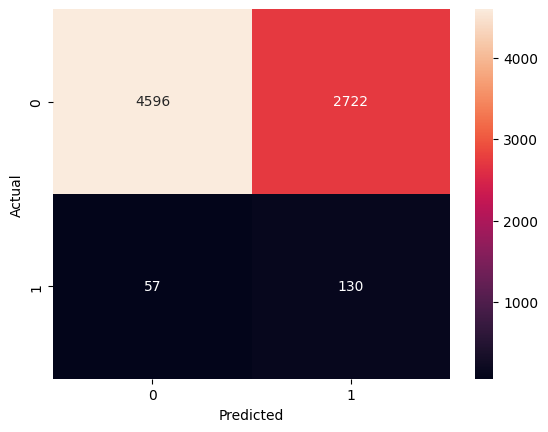

In [22]:
# Assuming y_test and y_pred are defined
cm = confusion_matrix(y_test, y_pred)

# Plot it
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Calcular la probabilidad de exito de los productos para cada cliente en el set de prueba

In [23]:
testing_data = data.loc[data['date'] > date]
testing_data['probability'] = model.predict_proba(X_test)[:, 1]

def get_top(df, input_dict, top_n):
    filtered_df = df[(df['Brand'] == input_dict['Brand']) & (df['Size'] == input_dict['Size']) & (df['ProductType'] == input_dict['ProductType']) & (df['GlobalCategory'] == input_dict['GlobalCategory']) & (df['GlobalFlavor'] == input_dict['GlobalFlavor']) & (df['ProductCategory'] == input_dict['ProductCategory'])]
    return filtered_df.sort_values('probability', ascending=False).head(top_n)["CustomerId"].to_list(), filtered_df.sort_values('probability', ascending=False).head(top_n)

Vamos a hacer una prueba con un producto en especifico

In [ ]:
# filter by {'Material_desc': 'MIX 473 ML LAT 4(1MP1MMGO1MLOW1MORIG)', 'Productos_Por_Empaque': 4, 'BrandPresRet': 'MONSTER ENERGY 473 ML NO RETORNABLE', 'ProdKey': 'BEBIDAS ENERGETICAS', 'Brand': 'MONSTER ENERGY', 'Presentation': 'LATA 473 ML', 'MLSize': 473, 'Returnability': 'NO RETORNABLE', 'Pack': '473 ML', 'Size': 'INDIVIDUAL', 'Flavor': 'SURTIDA', 'Container': 'LATA', 'Ncb': 0, 'ProductType': 'BEBIDAS ENERGETICAS', 'ProductCategory': 'CATEGORIAS EN EXPANSION', 'SegAg': 'BEBIDAS ENERGETICAS', 'SegDet': 'BEBIDAS ENERGETICAS', 'GlobalCategory': 'BEBIDAS EMERGENTES', 'GlobalSubcategory': 'ENERGÉTICOS', 'BrandGrouper': 'MONSTER', 'GlobalFlavor': 'MIXTO'}

In [25]:
input_dict = {'Brand': 'MONSTER ENERGY', 'Size': 'INDIVIDUAL', 'ProductType': 'BEBIDAS ENERGETICAS', 'GlobalCategory': 'BEBIDAS EMERGENTES', 'GlobalFlavor': 'MIXTO', 'ProductCategory': 'CATEGORIAS EN EXPANSION'}

top_50_list, top_50_df = get_top(testing_data, input_dict, 50)

In [31]:
top_50_df[["CustomerId", "probability"]].set_index("CustomerId")

,probability
CustomerId,
499930861,0.471995
499968994,0.443180
500147703,0.439536
500009869,0.436760
500118167,0.429275
500017777,0.423007
500113303,0.421691
499926963,0.417964
499972290,0.415622


In [29]:
top_50_df[["CustomerId", "probability"]].set_index("CustomerId").head()

,probability
CustomerId,
499930861,0.471995
499968994,0.443180
500147703,0.439536
500009869,0.436760
500118167,0.429275


In [30]:
top_50_df[["CustomerId", "probability"]].set_index("CustomerId").tail()

,probability
CustomerId,
500010092,0.296036
500120816,0.292944
500196332,0.292756
500270761,0.283161
500038823,0.273766


De acuerdo al producto especificado, se pueden observar los siguientes resultados.

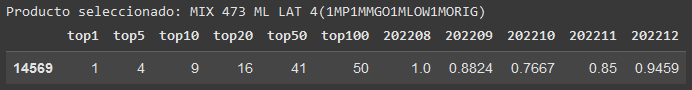

De los clientes seleccionados:
- Logramos predecir el cliente top 1
- 4 del top 5
- 9 del top 10
- 16 del top 20
- 41 del top 50
- El 94% de los clientes que marcamos estuivieron hasta diciembre de 2022